# Query Google Earth Engine (GEE) for reference DEM to use the SkySat triplet stereo pipeline

In [1]:
import os, glob, ee
import numpy as np
import geopandas as gpd
import geedim as gd
import matplotlib.pyplot as plt
import math
import xarray as xr

/Users/raineyaberle/opt/anaconda3/envs/snow-dems/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define input and output files

In [2]:
buffer = 20e3 # [m] how much to buffer the AOI before clipping DEM 

site_name = 'Sperry'
site_path = f'/Volumes/LaCie/raineyaberle/Research/PhD/SnowDEMs/{site_name}/'
aoi_fn = os.path.join(site_path, 'AOIs', f'{site_name}_outline.shp')
dem_path = os.path.join(site_path, 'refdem')

## Load area of interest (AOI) and buffer

In [3]:
def convert_wgs_to_utm(lon: float, lat: float):
    """
    Return best UTM epsg-code based on WGS84 lat and lon coordinate pair

    Parameters
    ----------
    lon: float
        longitude coordinate
    lat: float
        latitude coordinate

    Returns
    ----------
    epsg_code: str
        optimal UTM zone, e.g. "EPSG:32606"
    """
    utm_band = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0' + utm_band
    if lat >= 0:
        epsg_code = 'EPSG:326' + utm_band
        return epsg_code
    epsg_code = 'EPSG:327' + utm_band
    return epsg_code

Detected UTM zone =  EPSG:32612


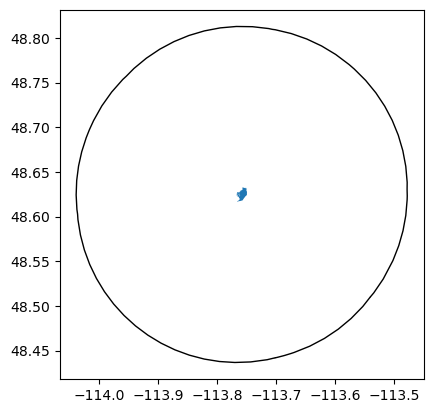

In [4]:
# Load the AOI
aoi = gpd.read_file(aoi_fn)
aoi_wgs = aoi.to_crs('EPSG:4326')

# Reproject to UTM
cen_lon = aoi.geometry[0].centroid.coords.xy[0][0]
cen_lat = aoi.geometry[0].centroid.coords.xy[1][0]
crs_utm = convert_wgs_to_utm(cen_lon, cen_lat)
print('Detected UTM zone = ', crs_utm)

# Buffer the AOI
aoi_utm = aoi.to_crs(crs_utm)
aoi_utm_buffer = aoi_utm.buffer(buffer)
aoi_wgs_buffer = aoi_utm_buffer.to_crs('EPSG:4326')

fig, ax = plt.subplots()
aoi_wgs.plot(ax=ax)
aoi_wgs_buffer.plot(ax=ax, facecolor='None', edgecolor='k')
plt.show()

## Initialize GEE

In [5]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Intialize()

## Query GEE for the NASA DEM, clip, save to file

In [6]:
def query_gee_for_dem(aoi, out_fn=None, crs='EPSG:4326', scale=30):
    """
    Query GEE for the ArcticDEM Mosaic (where there is coverage) or the NASADEM,
    clip to the AOI, and return as xarray.Dataset.

    Parameters
    ----------
    aoi: geopandas.geodataframe.GeoDataFrame
        area of interest used for clipping the DEM 
    out_fn: str
        file name for output DEM
    crs: str
        Coordinate Reference System of output DEM

    Returns
    ----------
    dem_ds: xarray.Dataset
        dataset of elevations over the AOI
    """

    # -----Reproject AOI to EPSG:4326 if necessary
    aoi_wgs = aoi.to_crs('EPSG:4326')

    # -----Reformat AOI for clipping DEM
    region = {'type': 'Polygon',
              'coordinates': [[
                  [aoi_wgs.geometry.bounds.minx[0], aoi_wgs.geometry.bounds.miny[0]],
                  [aoi_wgs.geometry.bounds.maxx[0], aoi_wgs.geometry.bounds.miny[0]],
                  [aoi_wgs.geometry.bounds.maxx[0], aoi_wgs.geometry.bounds.maxy[0]],
                  [aoi_wgs.geometry.bounds.minx[0], aoi_wgs.geometry.bounds.maxy[0]],
                  [aoi_wgs.geometry.bounds.minx[0], aoi_wgs.geometry.bounds.miny[0]]
              ]]
              }

    # -----Query for DEM
    dem = gd.MaskedImage.from_id("NASA/NASADEM_HGT/001", region=region)

    # -----Download DEM and open as xarray.Dataset
    # download DEM
    if not os.path.exists(out_fn):
        dem.download(out_fn, region=region, scale=scale, bands=['elevation'], crs=crs)
    # read DEM as xarray.Dataset
    dem_ds = xr.open_dataset(out_fn)

    # -----Plot
    fig, ax = plt.subplots()
    dem_im = ax.imshow(dem_ds.band_data.data[0], cmap='terrain',
              extent=(np.min(dem_ds.x.data), np.max(dem_ds.x.data), 
                      np.min(dem_ds.y.data), np.max(dem_ds.y.data)))
    fig.colorbar(dem_im, ax=ax, label='Elevation [m.a.s.l.]')
    ax.set_title(os.path.basename(out_fn))
    plt.show()
    
    return dem_ds

Sperry_NASADEM_clip_buffer_20km_EPSG32612.tif: |█| 4.12M/4.12M (raw) [100.0%] in


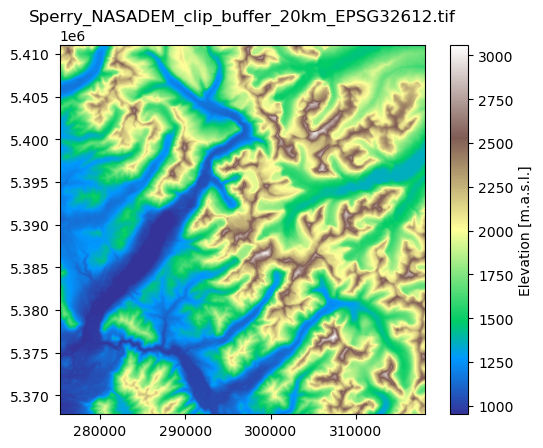

In [7]:
# Make sure output directory exists
if not os.path.exists(dem_path):
    os.mkdir(dem_path)
    print('Made directory for output file:', dem_path)
# Define output file name
dem_fn = os.path.join(dem_path, f"{site_name}_NASADEM_clip_buffer_{int(buffer/1e3)}km_{crs_utm.replace(':','')}.tif")
# Query and download DEM
dem_ds = query_gee_for_dem(aoi_wgs_buffer, out_fn=dem_fn, crs=crs_utm)